In [1]:
import numpy as np
import pandas as pd
import os
import pathlib

#current_dir = pathlib.Path(os.getcwd())
#data_dir = current_dir / 'data' / 'compressed_dataset'
data_dir = pathlib.Path('/kaggle/input/geolocation-geoguessr-images-50k/compressed_dataset')

print(f"Buscando imágenes en: {data_dir}")

# Escaneamos todas las imágenes .jpg y guardamos su ruta y su país (nombre de la carpeta)
filepaths = list(data_dir.glob(r'**/*.jpg'))
labels = [os.path.split(os.path.split(x)[0])[1] for x in filepaths]

df = pd.DataFrame({'Filepath': [str(x) for x in filepaths], 'Label': labels})

# Mezclamos los datos para que el modelo no aprenda países en orden
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())

Buscando imágenes en: /kaggle/input/geolocation-geoguessr-images-50k/compressed_dataset
                                            Filepath          Label
0  /kaggle/input/geolocation-geoguessr-images-50k...      Australia
1  /kaggle/input/geolocation-geoguessr-images-50k...  United States
2  /kaggle/input/geolocation-geoguessr-images-50k...          Japan
3  /kaggle/input/geolocation-geoguessr-images-50k...          Japan
4  /kaggle/input/geolocation-geoguessr-images-50k...      Australia


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

num_fotos_por_pais = df['Label'].value_counts()

# Umbral mínimo para incluir al país
MIN_IMAGENES = 5

paises_validos = num_fotos_por_pais[num_fotos_por_pais >= MIN_IMAGENES].index
df_filtrado = df[df['Label'].isin(paises_validos)].copy()

print(f"Dataset original: {len(df)} imágenes divididas en {len(num_fotos_por_pais)} países")
print(f"Dataset filtrado: {len(df_filtrado)} imágenes divididas en {len(paises_validos)} países")
print(f"Hemos eliminado {len(num_fotos_por_pais) - len(paises_validos)} países por tener menos de {MIN_IMAGENES} fotos")
print(f"Hemos eliminado {len(df) - len(df_filtrado)} imágenes de esos países")

# Usamos el 20% para validar
train_df, val_df = train_test_split(
    df_filtrado,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df_filtrado['Label'] # Puede ser útil, pues las fotos por país están desbalanceadas
)

print(f"Número de imágenes de entrenamiento: {len(train_df)}")
print(f"Número de imágenes de validación: {len(val_df)}")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2], # Simula diferencias de hora del día/nubes
    zoom_range=0.2,              # Simula ligeras variaciones en la cámara
    fill_mode='nearest',
    # horizontal_flip=True Lo quitamos, pues no queremos invertir el sentido de las carreteras
)

# Para validación solo reescalamos, sin ningún truco
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Cargamos las imágenes de entrenamiento
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

# Cargamos las imágenes de validación
val_images = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

2026-02-06 11:46:13.066617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770378373.091034    1097 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770378373.098175    1097 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770378373.117285    1097 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770378373.117319    1097 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770378373.117322    1097 computation_placer.cc:177] computation placer alr

Dataset original: 49997 imágenes divididas en 124 países
Dataset filtrado: 49967 imágenes divididas en 104 países
Hemos eliminado 20 países por tener menos de 5 fotos
Hemos eliminado 30 imágenes de esos países
Número de imágenes de entrenamiento: 39973
Número de imágenes de validación: 9994
Found 39973 validated image filenames belonging to 104 classes.
Found 9994 validated image filenames belonging to 104 classes.


In [3]:
from tensorflow.keras import layers, models

num_classes = len(train_images.class_indices)
print(f"Configurando salida para {num_classes} países.")

def crear_modelo_base():
    model = models.Sequential()

    # Captura bordes, colores simples (cielo, asfalto)
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2))) 

    # Captura texturas (hierba, patrones de carretera)
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Captura objetos más complejos (señales, formas de casas)
    # Aumentamos filtros a 128
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Como geolocalizar es difícil, añadimos una capa extra de 128 filtros
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Aplanamos los mapas de características a un vector 1D
    model.add(layers.Flatten())
    
    # Capa densa intermedia
    model.add(layers.Dense(512, activation='relu'))
    
    # Dropout para reducir el overfitting, útil en modelos desde cero 
    model.add(layers.Dropout(0.5)) 

    # Capa de salida con tantas neuronas como países
    # Activamos softmax por ser clasificación multiclase
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = crear_modelo_base()

model.summary()

Configurando salida para 104 países.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1770378380.241088    1097 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770378380.246268    1097 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 104)            │        53,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,134,312 (99.69 MB)

 Trainable params: 26,133,352 (99.69 MB)

 Non-trainable params: 960 (3.75 KB)

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Definimos el optimizador
opt = Adam(learning_rate=0.001)

# Definimos los callbacks
callbacks_list = [
    # Si val_loss no baja en 2 épocas, dividimos la velocidad por 4
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=2,
        factor=0.25,
        min_lr=0.00001,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]

In [5]:
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
history = model.fit(
    train_images,
    epochs=25,
    validation_data=val_images,
    callbacks=callbacks_list
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1770378386.499943    1161 service.cc:152] XLA service 0x7d9934007830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770378386.499997    1161 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770378386.500005    1161 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770378387.147986    1161 cuda_dnn.cc:529] Loaded cuDNN version 91002


   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:54 92ms/step - accuracy: 0.0547 - loss: 38.4270     

I0000 00:00:1770378394.241050    1161 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 360/1250 ━━━━━━━━━━━━━━━━━━━━ 9:22 632ms/step - accuracy: 0.1449 - loss: 10.5559

2026-02-06 11:50:22.839323: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:50:22.986322: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-06 11:50:23.128908: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 942s 745ms/step - accuracy: 0.1994 - loss: 6.4236 - val_accuracy: 0.2404 - val_loss: 3.4594 - learning_rate: 0.0010
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 800s 640ms/step - accuracy: 0.2418 - loss: 3.6286 - val_accuracy: 0.2404 - val_loss: 3.3513 - learning_rate: 0.0010
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 816s 653ms/step - accuracy: 0.2395 - loss: 3.4519 - val_accuracy: 0.2404 - val_loss: 3.3641 - learning_rate: 0.0010
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.2421 - loss: 3.3772
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 800s 640ms/step - accuracy: 0.2421 - loss: 3.3772 - val_accuracy: 0.2404 - val_loss: 3.3727 - learning_rate: 0.0010
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 806s 645ms/step - accuracy: 0.2391 - loss: 3.3448 - val_accuracy: 0.2404 - val_loss: 3.3420 - learning_rate: 2.5000e-04
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 820s 656ms/step - ac

In [7]:
save_path = '/kaggle/working/mi_modelo_geoguessr.keras'
model.save(save_path)
print(f"Modelo guardado exitosamente en: {save_path}")

Modelo guardado exitosamente en: /kaggle/working/mi_modelo_geoguessr.keras


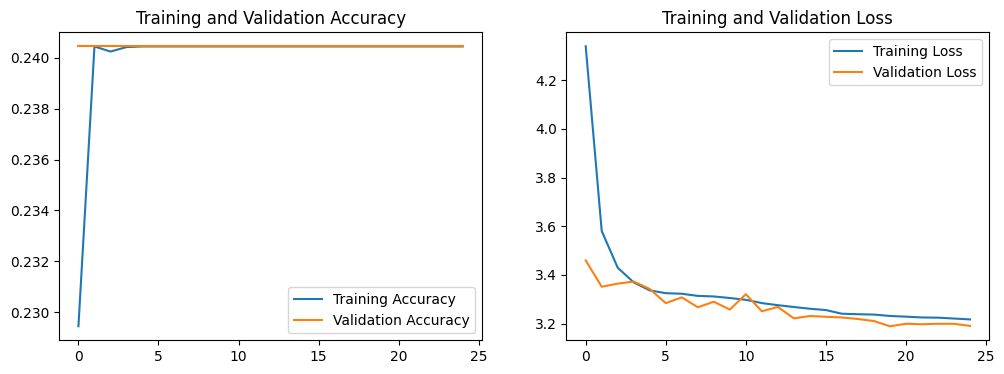

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Gráfico de Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Gráfico de Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


--- Probando predicciones en 5 imágenes aleatorias de validación ---


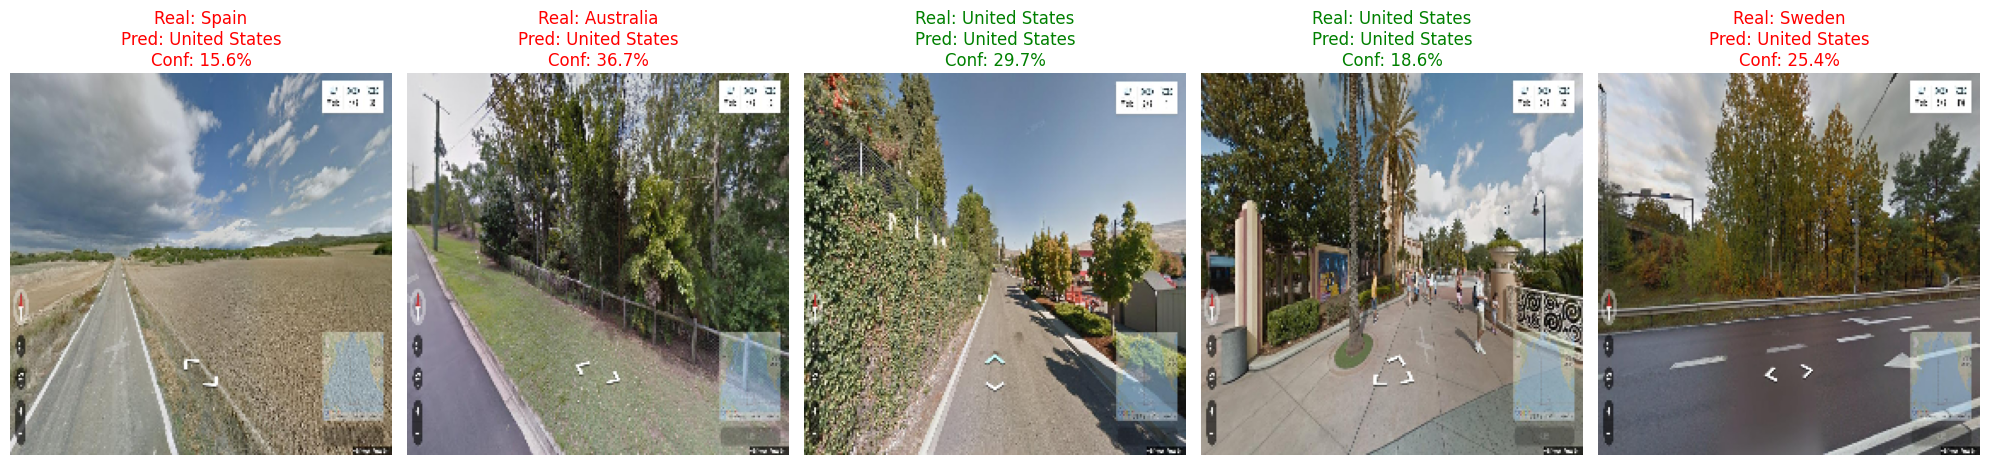

In [9]:
print("\n--- Probando predicciones en 5 imágenes aleatorias de validación ---")

# Obtenemos un mapeo inverso de índices a nombres de países (ej: 0 -> 'Spain')
labels_map = {v: k for k, v in train_images.class_indices.items()}

# Sacamos un lote de imágenes del generador de validación
# next() nos devuelve (imágenes, etiquetas_reales)
sample_images, sample_labels = next(val_images)

# Elegimos 5 índices al azar dentro de este lote
random_indices = np.random.choice(range(len(sample_images)), size=5, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    image = sample_images[idx]
    true_label_idx = np.argmax(sample_labels[idx])
    true_country = labels_map[true_label_idx]
    
    # Hacemos la predicción
    prediction_scores = model.predict(np.expand_dims(image, axis=0), verbose=0)
    predicted_label_idx = np.argmax(prediction_scores)
    predicted_country = labels_map[predicted_label_idx]
    confidence = np.max(prediction_scores) * 100
    
    # Mostramos la imagen
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    
    # Pintamos el título de color verde si acierta y de rojo si falla
    color = 'green' if true_country == predicted_country else 'red'
    
    plt.title(f"Real: {true_country}\nPred: {predicted_country}\nConf: {confidence:.1f}%", 
              color=color, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()